# Visually Shaping Distributions with TrafPy

This Notebook shows an example of how to shape distributions with `TrafPy`. We will save our shaped distributions, re-load them, and use them to generate custom flow-centric traffic data, which we will then save in .pickle format such that you'd be able to import the traffic into any simulation, emulation, or experimentation environment. We will also organise the demonstrated traffic into time slots and generate an sqlite data base which we can save to our disk and access during a simulation, thereby enabling us to scale to very large simulation sizes.

Import the `trafpy.generator` module

In [1]:
import trafpy.generator as tpg

Set global path

In [2]:
from pathlib import Path
import gzip
import pickle

PATH = 'data/visually_shape_and_generate_custom_traffic/'
Path(PATH).mkdir(exist_ok=True, parents=True)

## Generate Random Variables from 'Named' Distribution

Generate a distribution of random variables using one of the following standard named distributions:

- exponential
- lognormal
- weibull
- pareto

This might be e.g. interarrival times, sizes, number of nodes in a job, probability of job dependency/edge formation etc...

Note that to turn on the interactive functionality of these plotting functions, we simply set `interactive_plot=True`.

In the below example, try setting the arguments as `dist='weibull'`, `min_val=None`, `max_val=None`, `round_to_nearest=None`, and `size=150000`. Run the cell, and set the `TrafPy` parameters which pop up as `_alpha=5` and `_lambda=0.5` before clicking 'Run Interact'. You will see a print out of the distribution characteristics you've generated, a histogram, and the corresponding CDF. Feel free to play around with these parameters and to enter different named distribution names to shape your own distributions.

In [3]:
rand_vars = tpg.gen_named_val_dist(dist='weibull',
                                   interactive_plot=True,
                                   xlim=None, # [1, 10000] None
                                   min_val=None, # 50 None
                                   max_val=None, # 200 None
                                   round_to_nearest=None, # None 25
                                   num_decimal_places=2,
                                   rand_var_name='Random Variable',
#                                    prob_rand_var_less_than=[4847, 9431],
                                   num_bins=0,
                                   size=150000)

interactive(children=(FloatText(value=5.0, description='_alpha:', step=0.1), FloatText(value=0.5, description=…

Note that to use our `TrafPy` parameters to re-generate a distribution we've visually shaped, we simply make a note of the parameters and enter them into the same function but now setting `interactive_plot=False`. This is a key feature of `TrafPy` which enables users to share and re-generate distributions and traffic data given only a handful of `TrafPy` parameters.

E.g. Assuming we shaped a distribution with `TrafPy` parameters `dist='weibull'`, `min_val=None`, `max_val=None`, `round_to_nearest=None`, and named distribution parameters `_alpha=5` and `_lambda=0.5`, we would reproduce this distribution with:

In [4]:
dist = tpg.gen_named_val_dist(dist='weibull',
                              interactive_plot=False,
                              params={'_alpha': 5, '_lambda': 0.5},
                              round_to_nearest=None,
                              min_val=None,
                              max_val=None)

In [5]:
# save
filename = PATH+'random_variable.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(rand_vars.result, f)

## Generate Random Variables from Arbitrary 'Multimodal' Distribution

In previous cells we considered standard distributions (exponential, lognormal, weibull, pareto...). These are common distributions which occur in many different scenarios. However, sometimes in real scenarios distributions might not fall into these well-defined distribution categories. 

Multimodal distributions are distributions with >= 2 different modes. A multimodal distribution with 2 modes is a special case called a 'bimodal distribution', which is very common. 

The traffic toolbox allows you to generate arbitrary multimodal distributions. This is very powerful because with access to the above standard distributions and the arbitrary multimodal distribution generator, any distribution can be generated if you are able to shape it sufficiently.

Generating multimodal distributions is a little more involved than generating the standard distributions was, but it can still be done in a matter of seconds using `TrafPy`. 

There are a few simple steps to generating an arbitrary multimodal distribution:

1. Decide the number of modes (i.e. peaks) and other distribution characteristics
2. Shape each mode individually
3. Combine all of modes together and add some 'background noise' to the distribution such that the modes are 'joined' together to form a single multimodal distribution (background noise can be set to 0 if desired)
4. Use your multimodal distribution to generate demands
5. Save the generated demands

In [6]:
# 1. define distribution variables
min_val=1
max_val=1e5
num_modes=2
xlim=None
rand_var_name='Random Variable'
round_to_nearest=1
num_decimal_places=1

In [7]:
# 2. shape each mode
data_dict = tpg.gen_skew_dists(min_val=min_val,
                               max_val=max_val,
                               num_modes=num_modes,
                               xlim=xlim,
                               rand_var_name=rand_var_name,
                               round_to_nearest=round_to_nearest,
                               num_decimal_places=num_decimal_places)

interactive(children=(BoundedIntText(value=50000, description='Location:', max=100000, min=1), FloatText(value…

interactive(children=(BoundedIntText(value=50000, description='Location:', max=100000, min=1), FloatText(value…

In [8]:
# 3. combine modes to form multimodal distribution
multimodal_prob_dist = tpg.combine_multiple_mode_dists(data_dict,
                                                       min_val=min_val,
                                                       max_val=max_val,
                                                       xlim=xlim,
                                                       rand_var_name=rand_var_name,
                                                       round_to_nearest=round_to_nearest,
                                                       num_decimal_places=num_decimal_places)

interactive(children=(FloatText(value=0.5, description='bg_factor', step=0.001), Checkbox(value=False, descrip…

In [9]:
# 4. use dist to generate random variables
rand_vars = tpg.gen_rand_vars_from_discretised_dist(unique_vars=list(multimodal_prob_dist.result.keys()),
                                                    probabilities=list(multimodal_prob_dist.result.values()),
                                                    num_demands=150000)

AttributeError: 'NoneType' object has no attribute 'keys'

In [ ]:
# 5. save
filename = PATH+'multimodal_random_variable.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(rand_vars, f)

## Generate Discrete Probability Distribution from Random Variables

Previous cells generated random variable data. However, sometimes it might be desirable to have the probability distribution/probability mass function (PMF) of the generated data rather than all the original generated data. Using the PMF, anyone can sample randomly from the PMF to produce new data with similar characteristics to the original data which you generated.

Run this cell to load your previously generated distribution data and convert it into a PMF

In [10]:
filename = 'random_variable.pickle'
with gzip.open(PATH+'random_variable.pickle', 'rb') as f:
    rand_vars = pickle.load(f)
xk, pmf = tpg.gen_discrete_prob_dist(rand_vars, 
                                     round_to_nearest=None,
                                     num_decimal_places=2)
prob_dist = {var: prob for var,prob in zip(xk, pmf)}

TypeError: 'NoneType' object is not iterable

In [ ]:
# save
filename = PATH+'prob_dist.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(prob_dist, f)

## Generate Random Variables from Discrete Probability Distribution

Load a previously saved distribution and sample from it to generate any number of random variable data points. This function/cell does not plot the distribution, which avoids long delay times when trying to generate very large amounts of data.

In [11]:
with gzip.open(PATH+'prob_dist.pickle', 'rb') as f:
    prob_dist = pickle.load(f)
rand_vars = tpg.gen_rand_vars_from_discretised_dist(unique_vars=list(prob_dist.keys()),
                                                    probabilities=list(prob_dist.values()),
                                                    num_demands=150000)

In [12]:
# save
filename = PATH+'random_variables_from_prob_dist.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(rand_vars, f)

## Generate Source-Destination Node Distribution

Generate a matrix describing the traffic distribution of each source-node pair in a network.

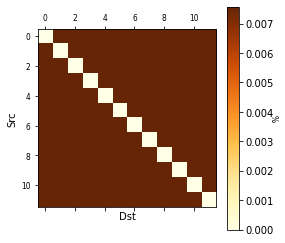

Src-dst edge weights in chord diagram are all the same, leading to 0 rescaled values. Decrease chord_edge_display_threshold to ensure a range of edge values are included in the chord diagram.


In [13]:
net = tpg.gen_arbitrary_network(num_eps=12, ep_label='ep')
ENDPOINTS = net.graph['endpoints']

# comment out all except one below

node_dist, _ = tpg.gen_uniform_node_dist(eps=ENDPOINTS,
                                         show_fig=True,
                                         print_data=False)

# node_dist, _ = tpg.gen_multimodal_node_dist(eps=ENDPOINTS,
#                                             skewed_nodes=[],
#                                             skewed_node_probs=[],
#                                             num_skewed_nodes=None,
#                                             show_fig=True,
#                                             print_data=True)

# node_dist, _ = tpg.gen_multimodal_node_pair_dist(eps=ENDPOINTS,
#                                                  skewed_pairs=[],
#                                                  skewed_pair_probs=[],
#                                                  num_skewed_pairs=None,
#                                                  show_fig=True,
#                                                  print_data=True)

In [14]:
# save
filename = PATH+'node_dist.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(node_dist, f)

## Use Node Distribution to Generate Source-Destination Node Demands

Sample from a previously generated source-destination matrix to generate source-destination node pair demands.

In [15]:
with gzip.open(PATH+'node_dist.pickle', 'rb') as f:
    node_dist = pickle.load(f)
node_demands = tpg.gen_node_demands(eps=ENDPOINTS,
                                    node_dist=node_dist,
                                    num_demands=150000)

In [16]:
# save
filename = PATH+'node_demands.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(node_demands, f)

## Use Previously Generated Distributions to Create Flow-Centric 'Demand Data' Dictionary

`TrafPy` can use your custom distributions to generate a `demand_data` traffic data set using the `trafpy.generator.create_demand_data()` function:

In [17]:
# flow-centric demand data
with gzip.open(PATH+'node_dist.pickle', 'rb') as f:
    node_dist = pickle.load(f)
with gzip.open(PATH+'prob_dist.pickle', 'rb') as f:
    flow_size_dist = pickle.load(f)
with gzip.open(PATH+'prob_dist.pickle', 'rb') as f:
    interarrival_time_dist = pickle.load(f)
    
network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                       'ep_link_capacity': net.graph['ep_link_capacity'],
                       'target_load_fraction': 0.1}

flow_centric_demand_data = tpg.create_demand_data(eps=ENDPOINTS,
                                                  node_dist=node_dist,
                                                  flow_size_dist=flow_size_dist,
                                                  interarrival_time_dist=interarrival_time_dist,
                                                  network_load_config=network_load_config,
                                                  print_data=True)

# save
filename = PATH+'custom_demand_data.pickle'
with gzip.open(filename, 'wb') as f:
    pickle.dump(flow_centric_demand_data, f)

Packed 2008295 flows in 779.6002013683319 s.


`demand_data` is a dictionary storing the following information for each flow (where the values are a list of values corresponding to the values assigned to each flow):

In [18]:
print('Flow data keys:\n{}'.format(flow_centric_demand_data.keys()))

Flow data keys:
dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index'])


## Analyse the Generated Traffic

At this point, you could do your own analysis of the traffic you've generated by loading the saved data into your own scripts. However, `TrafPy` provides some useful tools for this.

We can encode our saved `demand_data` files as `trafpy.generator.Demand()` objects, and then use the `trafpy.generator.DemandsAnalyser` and `trafpy.generator.DemandPlotter` objects to analyse them:

In [19]:
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter

First collect the demand objects from each demand_data file:

In [20]:
# collect demand objects
demands = {}
with gzip.open(PATH+'custom_demand_data.pickle', 'rb') as f:
    demand_data = pickle.load(f)
demands['custom'] = Demand(demand_data, net.graph['endpoints'], name='custom')

Then use `trafpy.generator.DemandsAnalyser()` to print a summary table of all the demand data sets you generated:

In [21]:
# print summary table
analyser = DemandsAnalyser(*list(demands.values()), jobcentric=False)
analyser.compute_metrics(print_summary=True)

,Name,Flows,1st,Last,Duration,Info,Load,Smallest,Largest
0,custom,2008295,0.0,122.887291,122.887291,921654.683418,7500.0,0.046255,0.806834


Finally, visualise your data:

custom
Characteristics of Flow Size distribution: DescribeResult(nobs=2008295, minmax=(0.046254741475075176, 0.8068340994951224), mean=0.4589239546070657, variance=0.011063943070940253, skewness=-0.2560497390126243, kurtosis=-0.11203572760306013)


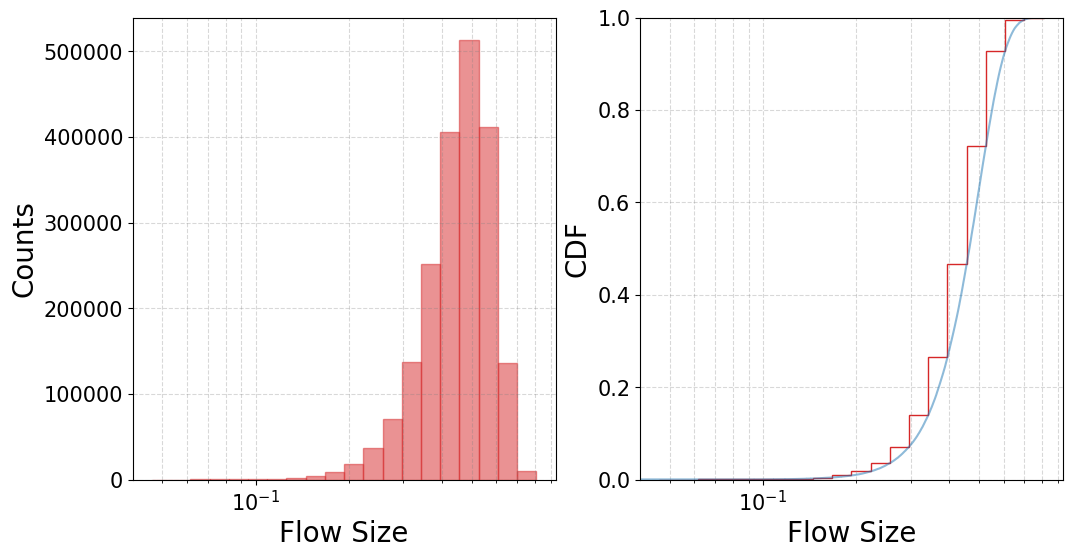

Characteristics of Interarrival Time distribution: DescribeResult(nobs=2008294, minmax=(6.167494547071328e-06, 0.00010758129340615596), mean=6.118989108284624e-05, variance=1.9706804845676754e-10, skewness=-0.25908088978369637, kurtosis=-0.1107051310995768)


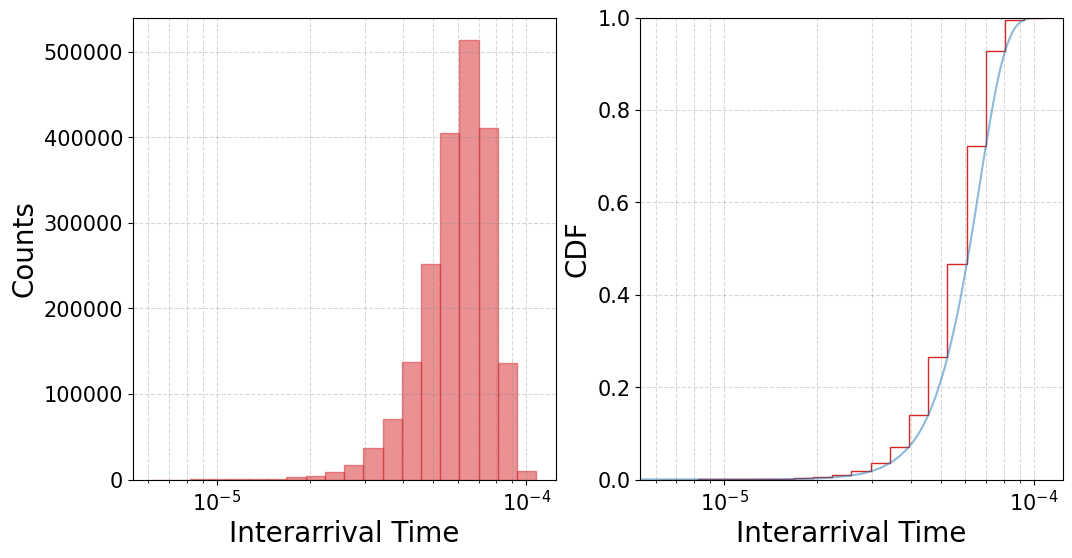

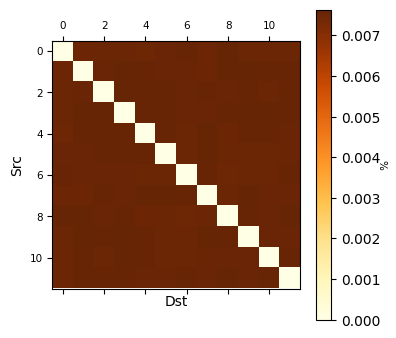

<Figure size 640x480 with 0 Axes>

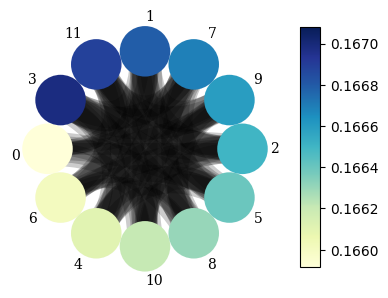

<Figure size 640x480 with 0 Axes>

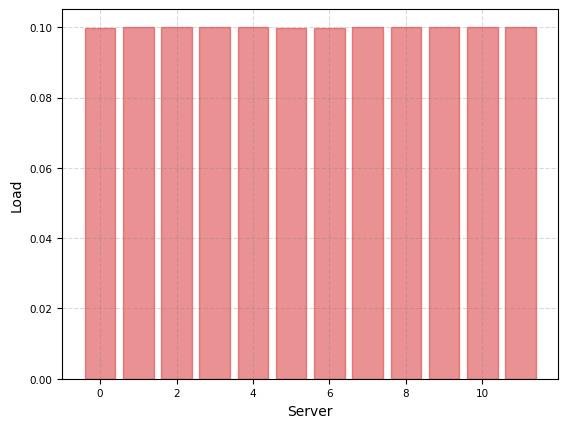

<Figure size 640x480 with 0 Axes>

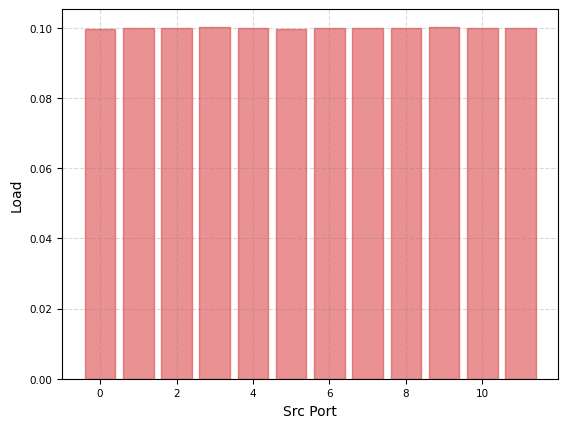

<Figure size 640x480 with 0 Axes>

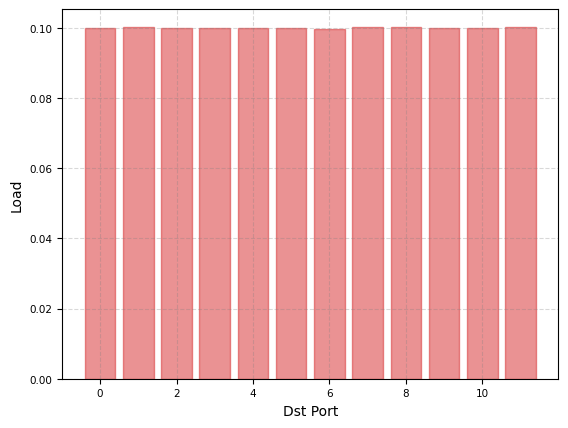

In [22]:
# visualise distributions
for name, demand in demands.items():
    print(name)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, figsize=(12,6))
    plotter.plot_interarrival_time_dist(logscale=True, figsize=(12,6))
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0.005)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'],
                                 plot_extras=False)

## Generate a slots dict data base

Many network experiments are based on time slots. I.e. during a time slot of e.g. 10 time units, some number of flows arrive. The `trafpy.generator.Demand()` class has a useful `get_slots_dict()` method to automatically organise your generated traffic demands into time slots given the `slot_size` you want to use:

In [23]:
slots_dict = demand.get_slots_dict(slot_size=10)

The `slots_dict` dictionary contains indices 0-n for `n` slots, as well as some other useful information:

In [24]:
print(slots_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'slot_keys', 'slot_size', 'time_first_demand_arrived', 'time_last_demand_arrived', 'job_centric', 'num_control_deps', 'num_data_deps', 'num_flows', 'num_demands'])


E.g. To access the flows which arrived in the first time slot (with upper bound and lower bound times on the time slot also given since this is often useful):

In [25]:
print(slots_dict[0].keys())

dict_keys(['lb_time', 'ub_time', 'new_event_dicts'])


Next time slot flows:

In [26]:
print(slots_dict[1].keys())

dict_keys(['lb_time', 'ub_time', 'new_event_dicts'])


And so on.

For large simulations, it is recommended to save the `slots_dict` as a database on your disk which you can query during your simulation. The `SqliteDict` library is particularly useful for this since it lets you save a database in .sqlite file format whilst still allowing you to query the database as if it were a normal Python dictionary. See [here](https://pypi.org/project/sqlitedict/) for more details.

To save your `slots_dict` as a .sqlite database with `SqliteDict`, run:

In [27]:
from sqlitedict import SqliteDict
import json

with SqliteDict(PATH+'custom_demand_data_slots_dict.sqlite') as _slots_dict:
    for key, val in slots_dict.items():
        if type(key) is not str:
            _slots_dict[json.dumps(key)] = val
        else:
            _slots_dict[key] = val
    _slots_dict.commit()
    _slots_dict.close()